In [ ]:
#Doing PCA with the entire protein-ligand cocrystal traj and on backbone atom distances

In [1]:
import pyemma
import glob
import numpy as np
import pyemma.plots as mplt
%pylab inline
import mdtraj as md
import pyemma.coordinates as coor
 
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res
 
def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg


Populating the interactive namespace from numpy and matplotlib


In [12]:

trajfile = []
for i in range(1,6):
    path = '/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/joined_holo_md_'+str(i)+'.nc'
    trajfile.append(path)
print(trajfile)

#assigns the features, which in this case is backbone atom positions
feat = coor.featurizer('/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/holo_top.h5')
feat.add_selection(feat.select_Backbone())
print(feat.describe()[:13])

#defining the trajs and features without loading into memory
inp = coor.source(trajfile, feat)
print(inp)
print('trajectory length = ',inp.trajectory_length(0))
print('number of dimension = ',inp.dimension())


['/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/joined_holo_md_1.nc', '/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/joined_holo_md_2.nc', '/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/joined_holo_md_3.nc', '/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/joined_holo_md_4.nc', '/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/joined_holo_md_5.nc']
['ATOM:ACE 0 C 4 x', 'ATOM:ACE 0 C 4 y', 'ATOM:ACE 0 C 4 z', 'ATOM:ILE 1 N 6 x', 'ATOM:ILE 1 N 6 y', 'ATOM:ILE 1 N 6 z', 'ATOM:ILE 1 CA 8 x', 'ATOM:ILE 1 CA 8 y', 'ATOM:ILE 1 CA 8 z', 'ATOM:ILE 1 C 23 x', 'ATOM:ILE 1 C 23 y', 'ATOM:ILE 1 C 23 z', 'ATOM:LEU 2 N 25 x']


trajectory length =  100000
number of dimension =  1962


In [18]:
print('trajectory length = ',inp.trajectory_length(0))

trajectory length =  100000


In [3]:
#running PCA

pca_obj = coor.pca(inp, dim= -1, var_cutoff=0.95) # all possible dimensions, execpt those limited by retained variance


Text(0, 0.5, 'principal comp. 2')

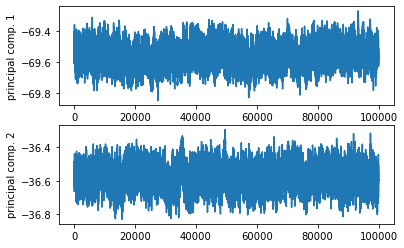

In [4]:
# this is looking at the first two PC's

Ypca = pca_obj.get_output()[0]

subplot2grid((2,1),(0,0))
plot(Ypca[:,0])
ylabel('principal comp. 1')
subplot2grid((2,1),(1,0))
plot(Ypca[:,1])
ylabel('principal comp. 2')

In [5]:
#This is clustering the PCA results by kmeans
Ypca = pca_obj.get_output()

cl = coor.cluster_kmeans(data=Ypca,k=10,max_iter=5000)

cl.converged

True

In [6]:
#defining discrete trajectories

dtrajs = cl.dtrajs
print(dtrajs)
print(np.size(dtrajs))

[array([9, 9, 9, ..., 8, 6, 6], dtype=int32), array([7, 7, 7, ..., 7, 7, 0], dtype=int32), array([3, 3, 3, ..., 3, 3, 3], dtype=int32), array([2, 2, 2, ..., 2, 2, 2], dtype=int32), array([4, 4, 4, ..., 4, 4, 4], dtype=int32)]
500000


IndexError: index 3 is out of bounds for axis 1 with size 3

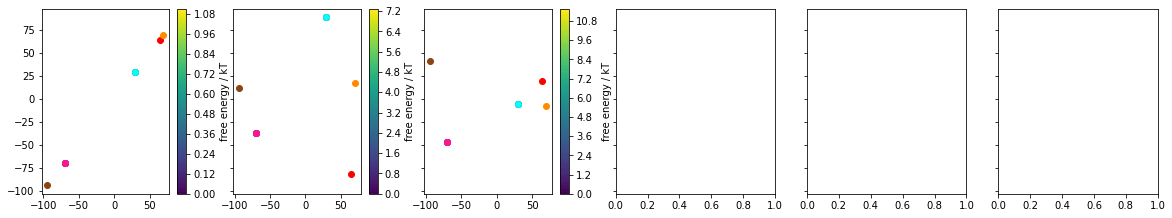

In [7]:
#plotting the free energy in subplots for tics 0-5

for s in range(6):
    fig, ax = plt.subplots(1, 6, sharex='col', sharey='row', figsize = (20,3.4)) #creating 1x6 subplot grid
    
    for w in range(6):
        mplt.plot_free_energy(np.vstack(Ypca)[:,s], np.vstack(Ypca)[:,w], ax = ax[w], cmap = 'viridis')#, cbar = False, cbar_label = None)
        cc_x = cl.clustercenters[:,s]
        cc_y = cl.clustercenters[:,w]
        #ax[w].plot(cc_x,cc_y, linewidth=0, marker='o', markersize=5, color='red')
        colors = ['black','gray','red','saddlebrown','darkorange','gold','darkgreen','aqua','darkviolet','deeppink']
        for i in range(10):
            ax[w].scatter(cc_x[i], cc_y[i], color = colors[i])
    
    for a in range(6):
        ax[a].set(xlabel = ('PC '+str(a)))
        
    fig.text(0.001, 0.5, 'PC '+str(s), va = 'center', rotation='vertical')
    
    fig.suptitle('PCA holo Cluster Centroids',fontsize = 16, y=1.06)
    fig.tight_layout()

    plt.savefig('/home/jegan/Clustering_methods/PCA/figs/PCA_holo/PCA_holo_FE_PC'+str(s)+'.png', bbox_inches = 'tight')


In [8]:
print(np.size(pca_obj.cumvar))
print(pca_obj.cumvar)
print(np.size(Ypca[0]))

1962
[0.51539027 0.87210041 0.96771325 ... 1.         1.         1.        ]
300000


In [19]:
#This prints the discrete trajectories we saved out before, then saves out the percent of frames in each cluster
print(dtrajs)
print(dtrajs[0])

with open('/home/jegan/Clustering_methods/PCA/PCA_holo.txt', 'w') as newfile:
    numb = []
    for i in range(10):
        frames = []
        for k in dtrajs:
            for p in k:
                if p == i:
                    frames.append(p)

        print(len(frames))
        numb.append(len(frames))
    
    newfile.write('Percent of frames per PCA holo cluster on the prot+lig md:\n')
    tot = 0
    index = 0
    for j in numb:
        tot += j
        percent = (j/500000)*100
        num = str(percent)
        newfile.write('Cluster '+ str(index)+' = '+num+' %\n')
        index += 1
    print(tot)


[array([9, 9, 9, ..., 8, 6, 6], dtype=int32), array([7, 7, 7, ..., 7, 7, 0], dtype=int32), array([3, 3, 3, ..., 3, 3, 3], dtype=int32), array([2, 2, 2, ..., 2, 2, 2], dtype=int32), array([4, 4, 4, ..., 4, 4, 4], dtype=int32)]
[9 9 9 ... 8 6 6]
51836
20757
100000
100000
100000
19571
19227
48164
20212
20233
500000


In [ ]:
#From here on it's clustering and extracting centroids, as well as saving out the centroid coords

In [27]:
#Extracting Centroids

avg = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]

indices = {}
for i in range(len(Ypca)):
    #for k in range(len(Y[0][i])):
    for k in range(len(Ypca[i])):
        c = cl.clustercenters[cl.dtrajs[i][k]]
        v = Ypca[i][k]
        newavg = np.linalg.norm(c-v)
        if avg[cl.dtrajs[i][k]] > newavg:
            avg[cl.dtrajs[i][k]] = newavg
            indices[cl.dtrajs[i][k]] = [i, k]
            
pdb0 = md.load('/home/jegan/final_centroids/XTAL/XTAL_0.pdb')

z = 0
for key in indices:
        z = z + 1
        index = indices[key][1]*(1 + indices[key][0])
        print(index)
        
        cen = md.load_frame('/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/entire_holo_md.nc', index, top = '/net/jam-amaro-shared/bccgc4/CatS_holo_md/joined_md/holo_top.h5')
        pdb = cen.superpose(pdb0,0)
        
        pdb.save_pdb('/home/jegan/Clustering_methods/PCA/PCA_holo_centroids/PCA_%s.pdb' % (z-1))

82249
60176
77534
89983
95982
126342
102122
168834
337304
496350
